# Federated Learning with FedAdam for Cybersecurity Dataset

This notebook implements federated learning using FedAdam optimization for cybersecurity attack detection.


In [11]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import our federated learning modules
from federated_learning.models import CyberSecurityNet
from federated_learning.client import FedClient
from federated_learning.server import FedAdamServer
from federated_learning.utils import prepare_data, create_data_loaders

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cpu
PyTorch version: 2.7.1


## Data Preparation

Loading and preprocessing the majority and minority datasets for federated learning.


In [12]:
# Prepare data for both majority and minority datasets
print("Preparing majority dataset...")
X_train_maj, X_test_maj, y_train_maj, y_test_maj, scaler_maj, le_maj = prepare_data('output/majority.csv')

print("\nPreparing minority dataset...")
X_train_min, X_test_min, y_train_min, y_test_min, scaler_min, le_min = prepare_data('output/minority.csv')

print(f"\nDataset Information:")
print(f"Majority dataset - Train: {X_train_maj.shape}, Test: {X_test_maj.shape}")
print(f"Minority dataset - Train: {X_train_min.shape}, Test: {X_test_min.shape}")
print(f"Number of features: {X_train_maj.shape[1]}")
print(f"Majority classes: {len(np.unique(y_train_maj))}")
print(f"Minority classes: {len(np.unique(y_train_min))}")

# Display class distributions
print(f"\nMajority dataset class distribution:")
unique_maj, counts_maj = np.unique(y_train_maj, return_counts=True)
for cls, count in zip(unique_maj, counts_maj):
    print(f"  Class {cls} ({le_maj.classes_[cls]}): {count} samples")

print(f"\nMinority dataset class distribution:")
unique_min, counts_min = np.unique(y_train_min, return_counts=True)
for cls, count in zip(unique_min, counts_min):
    print(f"  Class {cls} ({le_min.classes_[cls]}): {count} samples")


Preparing majority dataset...

Preparing minority dataset...

Dataset Information:
Majority dataset - Train: (273688, 68), Test: (68423, 68)
Minority dataset - Train: (1422, 68), Test: (356, 68)
Number of features: 68
Majority classes: 4
Minority classes: 4

Majority dataset class distribution:
  Class 0 (0.0): 97553 samples
  Class 1 (1.0): 78503 samples
  Class 2 (2.0): 54739 samples
  Class 3 (3.0): 42893 samples

Minority dataset class distribution:
  Class 0 (4.0): 1124 samples
  Class 1 (5.0): 153 samples
  Class 2 (6.0): 131 samples
  Class 3 (7.0): 14 samples


In [13]:
# Create data loaders for each client
batch_size = 64

train_loader_maj, test_loader_maj = create_data_loaders(
    X_train_maj, y_train_maj, X_test_maj, y_test_maj, batch_size
)

train_loader_min, test_loader_min = create_data_loaders(
    X_train_min, y_train_min, X_test_min, y_test_min, batch_size
)

print("Data loaders created successfully!")
print(f"Majority client - Train batches: {len(train_loader_maj)}, Test batches: {len(test_loader_maj)}")
print(f"Minority client - Train batches: {len(train_loader_min)}, Test batches: {len(test_loader_min)}")


Data loaders created successfully!
Majority client - Train batches: 4277, Test batches: 1070
Minority client - Train batches: 23, Test batches: 6


## Model Setup

Setting up the neural network architecture and determining the number of classes.


In [14]:
# Model parameters
input_dim = X_train_maj.shape[1]
num_classes_maj = len(np.unique(y_train_maj))
num_classes_min = len(np.unique(y_train_min))

# For federated learning, we'll use the maximum number of classes
max_classes = max(num_classes_maj, num_classes_min)

print(f"Model Configuration:")
print(f"Input dimension: {input_dim}")
print(f"Number of classes (majority): {num_classes_maj}")
print(f"Number of classes (minority): {num_classes_min}")
print(f"Using max classes for model: {max_classes}")

# Display model architecture
sample_model = CyberSecurityNet(input_dim, max_classes)
print(f"\nModel Architecture:")
print(sample_model)

# Count parameters
total_params = sum(p.numel() for p in sample_model.parameters())
trainable_params = sum(p.numel() for p in sample_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Configuration:
Input dimension: 68
Number of classes (majority): 4
Number of classes (minority): 4
Using max classes for model: 4

Model Architecture:
CyberSecurityNet(
  (fc1): Linear(in_features=68, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 19,300
Trainable parameters: 19,300


## Federated Learning Setup

Initializing the server and clients for federated learning with FedAdam optimization.


In [15]:
# Initialize global model
global_model = CyberSecurityNet(input_dim, max_classes)

# Initialize server with FedAdam
server = FedAdamServer(
    model=global_model,
    beta1=0.9,      # momentum parameter
    beta2=0.999,    # second moment parameter
    eta=0.01,       # server learning rate
    tau=1e-3        # regularization parameter
)

# Initialize clients
client_majority = FedClient(
    client_id="majority",
    model=CyberSecurityNet(input_dim, max_classes),
    train_loader=train_loader_maj,
    test_loader=test_loader_maj,
    device=device
)

client_minority = FedClient(
    client_id="minority",
    model=CyberSecurityNet(input_dim, max_classes),
    train_loader=train_loader_min,
    test_loader=test_loader_min,
    device=device
)

clients = [client_majority, client_minority]

print("Federated learning setup completed!")
print(f"Server: FedAdam with β1={server.beta1}, β2={server.beta2}, η={server.eta}")
print(f"Number of clients: {len(clients)}")
for client in clients:
    print(f"  - Client '{client.client_id}': {len(client.train_loader.dataset)} training samples")


Federated learning setup completed!
Server: FedAdam with β1=0.9, β2=0.999, η=0.01
Number of clients: 2
  - Client 'majority': 273688 training samples
  - Client 'minority': 1422 training samples


## Training Configuration

Setting up training parameters and metrics tracking.


In [16]:
# Training parameters
num_rounds = 50
local_epochs = 5
learning_rate = 0.001

# Tracking metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"Training Configuration:")
print(f"Number of communication rounds: {num_rounds}")
print(f"Local epochs per round: {local_epochs}")
print(f"Client learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print("\n" + "="*60)
print("Starting Federated Training...")
print("="*60)


Training Configuration:
Number of communication rounds: 50
Local epochs per round: 5
Client learning rate: 0.001
Batch size: 64

Starting Federated Training...


In [17]:
import time

start_time = time.time()

for round_num in range(num_rounds):
    round_start_time = time.time()
    print(f"\n🔄 Round {round_num + 1}/{num_rounds}")
    
    # Get global model parameters
    global_params = server.get_parameters()
    
    # Client training
    client_results = []
    
    for client in clients:
        # Set global parameters to client
        client.set_parameters(global_params)
        
        # Local training
        loss, num_samples = client.train(epochs=local_epochs, lr=learning_rate)
        
        # Get updated parameters
        updated_params = client.get_parameters()
        
        client_results.append((updated_params, num_samples, loss))
        print(f"  📱 Client {client.client_id}: Loss = {loss:.4f}, Samples = {num_samples}")
    
    # Server aggregation with FedAdam
    server.aggregate_fit(client_results)
    
    # Evaluation every 5 rounds or first round
    if (round_num + 1) % 5 == 0 or round_num == 0:
        eval_results = []
        
        # Update clients with new global model
        global_params = server.get_parameters()
        
        for client in clients:
            client.set_parameters(global_params)
            test_loss, test_acc = client.evaluate()
            eval_results.append((test_loss, test_acc, len(client.test_loader.dataset)))
            print(f"  📊 Client {client.client_id} Test: Loss = {test_loss:.4f}, Accuracy = {test_acc:.4f}")
        
        # Aggregate evaluation results
        avg_test_loss, avg_test_acc = server.aggregate_evaluate(eval_results)
        
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_test_acc)
        
        print(f"  🌐 Global Test: Loss = {avg_test_loss:.4f}, Accuracy = {avg_test_acc:.4f}")
    
    round_time = time.time() - round_start_time
    print(f"  ⏱️  Round time: {round_time:.2f}s")

total_time = time.time() - start_time
print(f"\n✅ Federated training completed!")
print(f"⏱️  Total training time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
print(f"🎯 Final Global Test Accuracy: {test_accuracies[-1]:.4f}")



🔄 Round 1/50
  📱 Client majority: Loss = 0.0185, Samples = 1368440
  📱 Client minority: Loss = 0.6577, Samples = 7110
  📊 Client majority Test: Loss = 1.3435, Accuracy = 0.5674
  📊 Client minority Test: Loss = 1.3463, Accuracy = 0.3848
  🌐 Global Test: Loss = 1.3435, Accuracy = 0.5664
  ⏱️  Round time: 24.54s

🔄 Round 2/50
  📱 Client majority: Loss = 0.0164, Samples = 1368440
  📱 Client minority: Loss = 0.6324, Samples = 7110
  ⏱️  Round time: 22.01s

🔄 Round 3/50
  📱 Client majority: Loss = 0.0147, Samples = 1368440
  📱 Client minority: Loss = 0.6195, Samples = 7110
  ⏱️  Round time: 22.00s

🔄 Round 4/50
  📱 Client majority: Loss = 0.0132, Samples = 1368440
  📱 Client minority: Loss = 0.6035, Samples = 7110
  ⏱️  Round time: 21.92s

🔄 Round 5/50
  📱 Client majority: Loss = 0.0135, Samples = 1368440
  📱 Client minority: Loss = 0.5889, Samples = 7110
  📊 Client majority Test: Loss = 0.8528, Accuracy = 0.9611
  📊 Client minority Test: Loss = 1.4733, Accuracy = 0.3567
  🌐 Global Test: Lo

## Training and Validation Accuracy & Loss Curves

If you want to track per-epoch training/validation loss and accuracy, you need to modify your client training loop to return these metrics. However, since your current setup only tracks global test loss/accuracy every 5 rounds, you can plot those as follows:

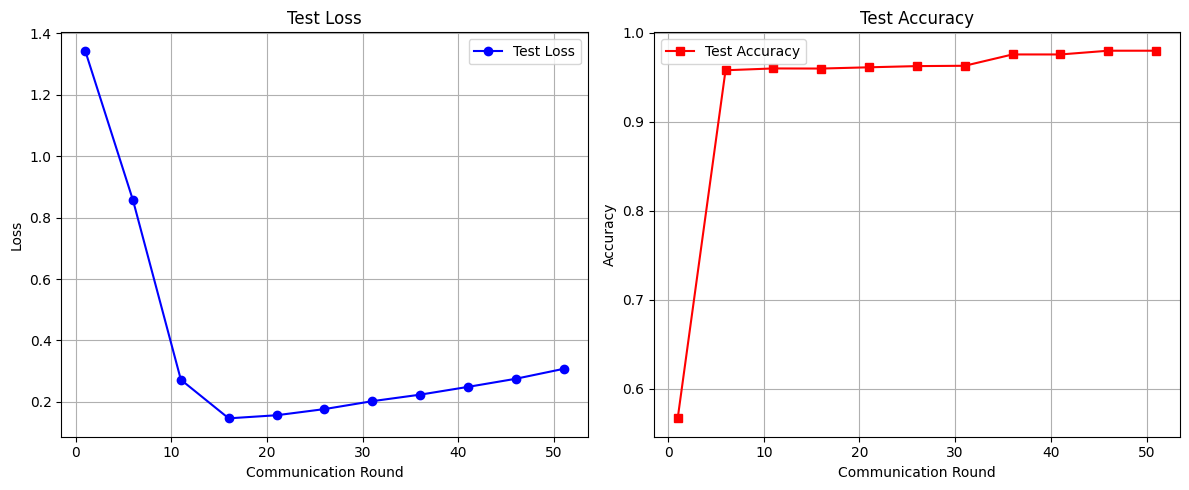

In [18]:
# Plot Test Loss and Test Accuracy over Communication Rounds

if 'test_losses' in globals() and 'test_accuracies' in globals():
    rounds_eval = list(range(1, len(test_losses) * 5 + 1, 5))
    if 1 not in rounds_eval:
        rounds_eval = [1] + rounds_eval

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rounds_eval[:len(test_losses)], test_losses, 'b-o', label='Test Loss')
    plt.xlabel('Communication Round')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(rounds_eval[:len(test_accuracies)], test_accuracies, 'r-s', label='Test Accuracy')
    plt.xlabel('Communication Round')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Error: test_losses and/or test_accuracies are not defined. Please run the training cells first.")


## Confusion Matrix

Evaluate your model on the test set and plot the confusion matrix for the majority client:

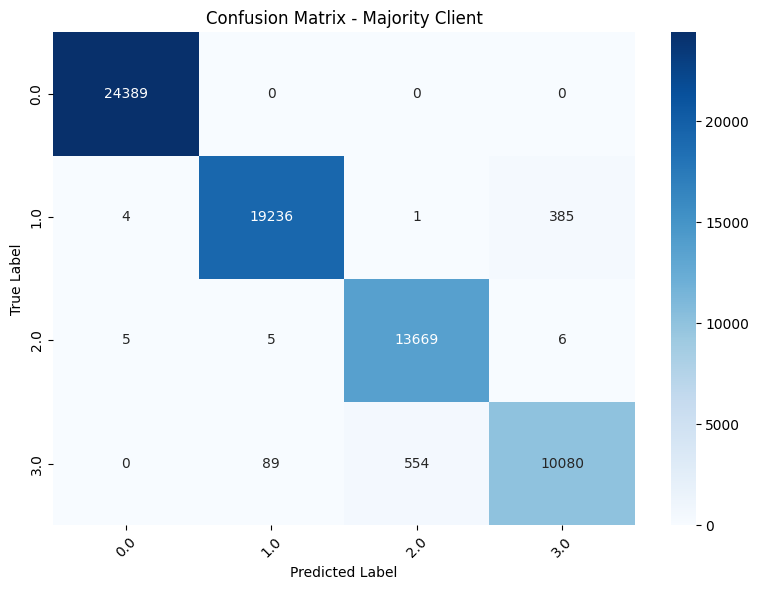

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure client_majority is defined
if 'client_majority' not in globals():
    print("client_majority is not defined. Please run the cell that initializes the clients (cell 8) before running this cell.")
else:
    # Get predictions and true labels for the majority client
    client_majority.set_parameters(server.get_parameters())
    client_majority.model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in client_majority.test_loader:
            data, target = data.to(device), target.to(device)
            output = client_majority.model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    label_names = le_maj.classes_

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix - Majority Client')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## ROC Curve (Multi-Class)

For multi-class ROC, use a one-vs-rest approach and plot a curve for each class:

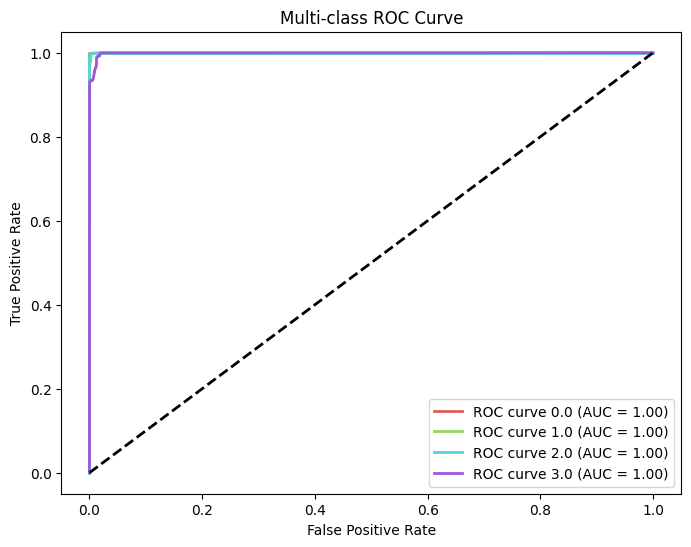

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_true_bin = label_binarize(all_targets, classes=np.arange(len(label_names)))
# Get softmax probabilities for ROC/PR
all_probs = []
with torch.no_grad():
    for data, _ in client_majority.test_loader:
        data = data.to(device)
        output = client_majority.model(data)
        probs = torch.softmax(output, dim=1)
        all_probs.append(probs.cpu().numpy())
all_probs = np.vstack(all_probs)

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = sns.color_palette("hls", len(label_names))
for i, color in zip(range(len(label_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve {label_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()


## Precision-Recall (PR) Curve (Multi-Class)

Plot a PR curve for each class:

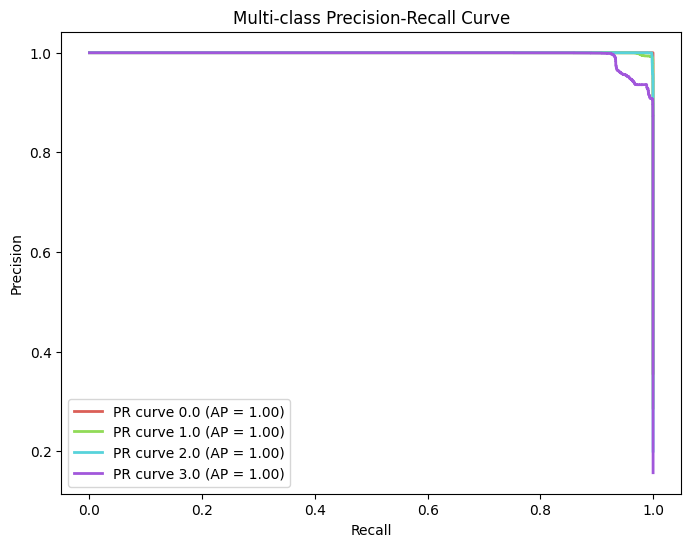

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(label_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(8, 6))
for i, color in zip(range(len(label_names)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'PR curve {label_names[i]} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
